In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to your JSON file in Drive
FILE_NAME = "/content/drive/MyDrive/all_metrics_2h.json"
OUTPUT_CSV = "/content/drive/MyDrive/all_metrics_pivot.csv"


In [ ]:
import json, pandas as pd, numpy as np

# Load JSON
with open(FILE_NAME, "r", encoding="utf-8") as f:
    raw = json.load(f)

rows = {}

for entry in raw.get("metrics", []):
    metric_name = entry.get("name")
    pdata = entry.get("data", {}).get("data", {})
    results = pdata.get("result", [])

    for r in results:
        labels = r.get("metric", {}).copy() or {}
        labels.pop("__name__", None)
        label_suffix = ",".join([f"{k}={v}" for k,v in sorted(labels.items())])
        metric_id = metric_name if not label_suffix else f"{metric_name}|{label_suffix}"

        ts_vals = {}
        for ts, val in r.get("values", []):
            ts = pd.to_datetime(int(ts), unit="s", utc=True)
            try:
                ts_vals[ts] = float(val)
            except:
                ts_vals[ts] = np.nan

        # Save one row = one metric
        rows[metric_id] = ts_vals

# Build DataFrame: rows=metric, cols=timestamps
pivot_df = pd.DataFrame.from_dict(rows, orient="index").sort_index(axis=1)

# Show first 5 rows × 10 columns
display(pivot_df.iloc[:5, :10])

# Save to CSV (timestamps as column headers)
pivot_df.to_csv(OUTPUT_CSV)
print("Saved pivot CSV to:", OUTPUT_CSV)


,2025-08-14 21:54:01+00:00,2025-08-14 21:55:01+00:00,2025-08-14 21:56:01+00:00,2025-08-14 21:57:01+00:00,2025-08-14 21:58:01+00:00,2025-08-14 21:59:01+00:00,2025-08-14 22:00:01+00:00,2025-08-14 22:01:01+00:00,2025-08-14 22:02:01+00:00,2025-08-14 22:03:01+00:00
"alloy_build_info|branch=HEAD,goarch=amd64,goos=linux,goversion=go1.24.4,instance=localhost:12345,job=alloy,revision=63aeef7,tags=netgo,builtinassets,promtail_journal_enabled,version=v1.10.0",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"alloy_component_controller_evaluating|controller_id=remotecfg,controller_path=/,instance=localhost:12345,job=alloy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"alloy_component_controller_evaluating|controller_path=/,instance=localhost:12345,job=alloy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"alloy_component_controller_running_components|controller_path=/,health_type=healthy,instance=localhost:12345,job=alloy",6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
"alloy_component_dependencies_wait_seconds_bucket|controller_id=remotecfg,controller_path=/,instance=localhost:12345,job=alloy,le=+Inf",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saved pivot CSV to: /content/drive/MyDrive/all_metrics_pivot.csv


In [ ]:
pivot_df.to_csv(OUTPUT_CSV)
print("Saved pivot CSV to:", OUTPUT_CSV)


Saved pivot CSV to: /content/drive/MyDrive/all_metrics_pivot.csv


In [ ]:
import pandas as pd
import re

# --- CONFIG ---
FILE_PATH = "/content/drive/MyDrive/all_metrics_pivot.csv"  # update if needed

# --- LOAD & FILTER (first column contains 'cpu') ---
df = pd.read_csv(FILE_PATH, low_memory=False)
col0 = df.columns[0]
cpu_df = df[df[col0].astype(str).str.contains("cpu", case=False, na=False)].copy()

# --- EXTRACT cpu label: works for forms like '...|cpu=0,instance=...' or '...{cpu="0",...}'
cpu_df["cpu"] = cpu_df[col0].str.extract(r'cpu\s*=\s*"?([^,|}"]+)"?', expand=False)

# Drop rows where cpu couldn't be parsed (just in case)
cpu_df = cpu_df[cpu_df["cpu"].notna()].copy()

# (Optional) normalize cpu to int when possible
def _maybe_int(x):
    return int(x) if isinstance(x, str) and x.isdigit() else x
cpu_df["cpu"] = cpu_df["cpu"].map(_maybe_int)

# --- SPLIT INTO SEPARATE DATAFRAMES ---
dfs_by_cpu = {cpu_val: g.reset_index(drop=True) for cpu_val, g in cpu_df.groupby("cpu", sort=True)}

# --- PREVIEW ---
print("CPU groups found:", sorted(dfs_by_cpu.keys(), key=lambda k: (isinstance(k, str), k)))
for cpu_val, sub in dfs_by_cpu.items():
    print(f"\n=== cpu={cpu_val} | shape={sub.shape} ===")
    try:
        # if in Jupyter/Colab, this will render nicely
        from IPython.display import display
        display(sub.head(5))
    except Exception:
        # fallback to plain text
        print(sub.head(5).to_string(index=False))

# Access specific DataFrames like:
# df_cpu0 = dfs_by_cpu[0]
# df_cpu1 = dfs_by_cpu[1]


CPU groups found: [0, 1, 2, 3]

=== cpu=0 | shape=(18, 123) ===


,Unnamed: 0,2025-08-14 21:54:01+00:00,2025-08-14 21:55:01+00:00,2025-08-14 21:56:01+00:00,2025-08-14 21:57:01+00:00,2025-08-14 21:58:01+00:00,2025-08-14 21:59:01+00:00,2025-08-14 22:00:01+00:00,2025-08-14 22:01:01+00:00,2025-08-14 22:02:01+00:00,...,2025-08-14 23:46:01+00:00,2025-08-14 23:47:01+00:00,2025-08-14 23:48:01+00:00,2025-08-14 23:49:01+00:00,2025-08-14 23:50:01+00:00,2025-08-14 23:51:01+00:00,2025-08-14 23:52:01+00:00,2025-08-14 23:53:01+00:00,2025-08-14 23:54:01+00:00,cpu
0,"node_cpu_seconds_total|cpu=0,instance=ctdev930...",141232.60,141291.15,141349.62,141408.15,141466.62,141525.04,141583.38,141640.76,141699.48,...,147778.64,147836.96,147895.52,147953.90,148012.32,148070.89,148129.46,148187.70,148246.13,0
1,"node_cpu_seconds_total|cpu=0,instance=ctdev930...",90.89,90.89,90.89,90.91,90.91,90.92,90.92,91.51,91.51,...,92.56,92.57,92.57,92.57,92.57,92.59,92.59,92.62,92.62,0
2,"node_cpu_seconds_total|cpu=0,instance=ctdev930...",609.90,610.17,610.48,610.77,611.07,611.35,611.67,611.89,612.10,...,640.18,640.51,640.81,641.13,641.44,641.70,641.94,642.28,642.59,0
3,"node_cpu_seconds_total|cpu=0,instance=ctdev930...",2.26,2.26,2.26,2.26,2.26,2.26,2.26,2.26,2.26,...,2.26,2.26,2.26,2.26,2.26,2.26,2.26,2.26,2.26,0
4,"node_cpu_seconds_total|cpu=0,instance=ctdev930...",247.24,247.35,247.46,247.56,247.67,247.76,247.87,247.98,248.07,...,258.76,258.87,258.99,259.10,259.22,259.32,259.42,259.55,259.68,0



=== cpu=1 | shape=(18, 123) ===


,Unnamed: 0,2025-08-14 21:54:01+00:00,2025-08-14 21:55:01+00:00,2025-08-14 21:56:01+00:00,2025-08-14 21:57:01+00:00,2025-08-14 21:58:01+00:00,2025-08-14 21:59:01+00:00,2025-08-14 22:00:01+00:00,2025-08-14 22:01:01+00:00,2025-08-14 22:02:01+00:00,...,2025-08-14 23:46:01+00:00,2025-08-14 23:47:01+00:00,2025-08-14 23:48:01+00:00,2025-08-14 23:49:01+00:00,2025-08-14 23:50:01+00:00,2025-08-14 23:51:01+00:00,2025-08-14 23:52:01+00:00,2025-08-14 23:53:01+00:00,2025-08-14 23:54:01+00:00,cpu
0,"node_cpu_seconds_total|cpu=1,instance=ctdev930...",141009.57,141067.86,141126.30,141184.72,141243.28,141301.65,141360.18,141417.95,141476.63,...,147564.39,147623.12,147681.56,147739.96,147798.29,147856.56,147915.12,147973.41,148031.67,1
1,"node_cpu_seconds_total|cpu=1,instance=ctdev930...",103.57,103.57,103.58,103.59,103.60,103.60,103.62,103.65,103.68,...,104.90,104.90,104.92,104.94,104.94,104.95,104.96,104.96,104.96,1
2,"node_cpu_seconds_total|cpu=1,instance=ctdev930...",636.22,636.56,636.84,637.14,637.41,637.69,637.98,638.21,638.44,...,666.77,667.01,667.31,667.62,667.96,668.31,668.57,668.90,669.27,1
3,"node_cpu_seconds_total|cpu=1,instance=ctdev930...",1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27,...,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1.27,1
4,"node_cpu_seconds_total|cpu=1,instance=ctdev930...",169.09,169.16,169.24,169.32,169.39,169.46,169.53,169.60,169.66,...,177.11,177.17,177.25,177.34,177.42,177.50,177.58,177.67,177.75,1



=== cpu=2 | shape=(18, 123) ===


,Unnamed: 0,2025-08-14 21:54:01+00:00,2025-08-14 21:55:01+00:00,2025-08-14 21:56:01+00:00,2025-08-14 21:57:01+00:00,2025-08-14 21:58:01+00:00,2025-08-14 21:59:01+00:00,2025-08-14 22:00:01+00:00,2025-08-14 22:01:01+00:00,2025-08-14 22:02:01+00:00,...,2025-08-14 23:46:01+00:00,2025-08-14 23:47:01+00:00,2025-08-14 23:48:01+00:00,2025-08-14 23:49:01+00:00,2025-08-14 23:50:01+00:00,2025-08-14 23:51:01+00:00,2025-08-14 23:52:01+00:00,2025-08-14 23:53:01+00:00,2025-08-14 23:54:01+00:00,cpu
0,"node_cpu_seconds_total|cpu=2,instance=ctdev930...",141083.81,141142.11,141200.35,141258.75,141317.12,141375.41,141433.91,141470.33,141529.18,...,147602.05,147660.42,147718.75,147777.10,147835.36,147893.41,147951.73,148010.11,148068.63,2
1,"node_cpu_seconds_total|cpu=2,instance=ctdev930...",99.46,99.48,99.49,99.50,99.50,99.52,99.52,99.56,99.56,...,100.69,100.71,100.71,100.71,100.72,100.79,100.79,100.80,100.80,2
2,"node_cpu_seconds_total|cpu=2,instance=ctdev930...",638.90,639.24,639.59,639.89,640.22,640.52,640.81,641.12,641.31,...,670.73,671.03,671.37,671.67,672.01,672.39,672.72,673.02,673.31,2
3,"node_cpu_seconds_total|cpu=2,instance=ctdev930...",3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,...,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,2
4,"node_cpu_seconds_total|cpu=2,instance=ctdev930...",164.51,164.57,164.65,164.73,164.80,164.88,164.96,165.01,165.06,...,172.11,172.19,172.25,172.32,172.40,172.48,172.55,172.62,172.69,2



=== cpu=3 | shape=(18, 123) ===


,Unnamed: 0,2025-08-14 21:54:01+00:00,2025-08-14 21:55:01+00:00,2025-08-14 21:56:01+00:00,2025-08-14 21:57:01+00:00,2025-08-14 21:58:01+00:00,2025-08-14 21:59:01+00:00,2025-08-14 22:00:01+00:00,2025-08-14 22:01:01+00:00,2025-08-14 22:02:01+00:00,...,2025-08-14 23:46:01+00:00,2025-08-14 23:47:01+00:00,2025-08-14 23:48:01+00:00,2025-08-14 23:49:01+00:00,2025-08-14 23:50:01+00:00,2025-08-14 23:51:01+00:00,2025-08-14 23:52:01+00:00,2025-08-14 23:53:01+00:00,2025-08-14 23:54:01+00:00,cpu
0,"node_cpu_seconds_total|cpu=3,instance=ctdev930...",141150.25,141208.78,141267.41,141325.88,141384.45,141442.93,141501.47,141556.24,141615.15,...,147693.97,147752.21,147810.75,147869.15,147927.82,147986.43,148044.58,148103.10,148161.56,3
1,"node_cpu_seconds_total|cpu=3,instance=ctdev930...",92.13,92.13,92.14,92.15,92.17,92.17,92.17,92.19,92.19,...,93.30,93.31,93.31,93.33,93.34,93.35,93.37,93.41,93.46,3
2,"node_cpu_seconds_total|cpu=3,instance=ctdev930...",620.35,620.63,620.90,621.19,621.46,621.74,622.03,622.30,622.49,...,650.77,651.13,651.40,651.71,651.96,652.22,652.57,652.82,653.08,3
3,"node_cpu_seconds_total|cpu=3,instance=ctdev930...",1.94,1.94,1.94,1.94,1.94,1.94,1.94,1.94,1.94,...,2.22,2.22,2.22,2.22,2.22,2.22,2.22,2.22,2.22,3
4,"node_cpu_seconds_total|cpu=3,instance=ctdev930...",154.37,154.45,154.51,154.58,154.64,154.71,154.78,154.83,154.88,...,161.59,161.66,161.72,161.79,161.85,161.93,162.00,162.07,162.13,3


In [ ]:
# --- SAVE EACH CPU GROUP TO ITS OWN CSV IN GOOGLE DRIVE ---
from pathlib import Path
import os

OUT_DIR = "/content/drive/MyDrive/cpu_metrics"  # <-- change to your Drive folder
os.makedirs(OUT_DIR, exist_ok=True)

base = Path(FILE_PATH).stem
saved_paths = []

for cpu_val, sub in dfs_by_cpu.items():
    # filename-safe cpu label
    cpu_label = re.sub(r'[^A-Za-z0-9._-]+', '_', str(cpu_val))
    out_path = Path(OUT_DIR) / f"{base}__cpu_{cpu_label}.csv"
    sub.to_csv(out_path, index=False)
    saved_paths.append(str(out_path))

print("Saved files:")
for p in saved_paths:
    print(" -", p)


Saved files:
 - /content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_0.csv
 - /content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_1.csv
 - /content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_2.csv
 - /content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_3.csv



=== CPU Health Summary (per CPU) ===
 cpu  samples  mean_util  p95_util  max_util  pct_time_high_util
   0      121   0.033949  0.029667       1.0            0.826446
   1      121   0.032769  0.029000       1.0            0.826446
   2      121   0.037904  0.035500       1.0            0.826446
   3      121   0.034255  0.030833       1.0            0.826446

Prepared feature matrix for anomaly detection: shape=(484, 15)
Feature columns: ['util', 'util_roll_mean', 'util_roll_std', 'util_roll_z', 'util_diff_1', 'util_diff_3', 'util_pct_change', 'util_roll_median', 'util_roll_iqr', 'util_roll_slope', 'hour', 'dow']

=== Sample utilization time series (first CPU) ===
                timestamp  cpu               instance     util
2025-08-14 21:54:01+00:00    0 ctdev9306.clonetab.com 1.000000
2025-08-14 21:55:01+00:00    0 ctdev9306.clonetab.com 0.024167
2025-08-14 21:56:01+00:00    0 ctdev9306.clonetab.com 0.025500
2025-08-14 21:57:01+00:00    0 ctdev9306.clonetab.com 0.024500
2025-08-14

/tmp/ipython-input-1489163465.py:218: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("cpu").apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


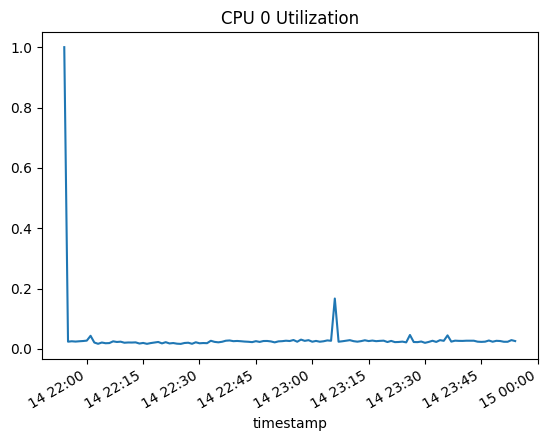

In [ ]:
# =======================
# CPU ANALYSIS + PREP FOR ANOMALY DETECTION (no training)
# =======================
# Works with per-CPU CSVs like:
#   all_metrics_pivot__cpu_0.csv, ... __cpu_1.csv, ... etc.
#
# Assumes the first column is the metric identifier string (e.g.,
# "node_cpu_seconds_total|cpu=0,mode=idle,instance=..."), and subsequent
# columns are time points (wide/pivot format).

# --- If using Google Colab + Drive, uncomment:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
from pathlib import Path
from glob import glob

# ===================== CONFIG =====================
# Point this to where your per-CPU CSVs are stored.
# Example (Drive): FILES_GLOB = "/content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_*.csv"
# Example (local): FILES_GLOB = "/mnt/data/all_metrics_pivot__cpu_*.csv"
FILES_GLOB = "/content/drive/MyDrive/cpu_metrics/all_metrics_pivot__cpu_*.csv"

# If timestamps in columns cannot be parsed, we assume equal spacing (Δt = 1s).
ASSUME_DELTA_SECONDS_WHEN_UNKNOWN = 1.0

# Rolling window (in number of samples) for features
ROLL_WIN = 12
# ==================================================


def _extract_label(text: str, key: str):
    """
    Extract label like cpu, mode, instance from a metric id string that may look like:
      - node_cpu_seconds_total|cpu=0,mode=idle,instance=ctdev...
      - node_cpu_seconds_total{cpu="0",mode="idle",instance="..."}
    Returns None if not found.
    """
    if not isinstance(text, str):
        return None
    # match both pipe or brace styles
    m = re.search(fr'{key}\s*=\s*"?([^,|}}"]+)"?', text)
    return m.group(1) if m else None


def wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    """Melt a wide/pivot CPU CSV into tidy columns: metric_id, timestamp_raw, value."""
    metric_col = df.columns[0]
    time_cols = [c for c in df.columns if c != metric_col]
    long_df = df.melt(id_vars=[metric_col], value_vars=time_cols,
                      var_name="timestamp_raw", value_name="value")
    long_df.rename(columns={metric_col: "metric_id"}, inplace=True)
    # numeric-ize
    long_df["value"] = pd.to_numeric(long_df["value"], errors="coerce")
    return long_df


def parse_timestamps(long_df: pd.DataFrame) -> pd.DataFrame:
    """
    Attempt to parse timestamp columns. If parsing fails for most columns,
    fall back to an integer index with constant Δt.
    """
    ts = pd.to_datetime(long_df["timestamp_raw"], errors="coerce", utc=True)
    if ts.isna().mean() < 0.5:  # we could parse at least half
        long_df["timestamp"] = ts
    else:
        # fallback: create a per-file ordinal timeline
        # we'll reorder by 'timestamp_raw' and treat it as an ordered index
        # NOTE: this assumes time columns are already in chronological order
        # in the CSV header.
        # Create a numeric order per metric_id so diffs still work.
        long_df["_col_order"] = long_df.groupby("metric_id")["timestamp_raw"].transform(
            lambda s: pd.factorize(s, sort=True)[0]
        )
        # Build a pseudo timestamp per metric row
        # Use start at 0 seconds + order index
        long_df["timestamp"] = pd.to_datetime(long_df["_col_order"], unit="s", utc=True)
    return long_df


def add_labels(long_df: pd.DataFrame) -> pd.DataFrame:
    """Extract cpu/mode/instance from the metric_id column."""
    long_df["cpu"] = long_df["metric_id"].map(lambda s: _extract_label(s, "cpu"))
    long_df["mode"] = long_df["metric_id"].map(lambda s: _extract_label(s, "mode"))
    long_df["instance"] = long_df["metric_id"].map(lambda s: _extract_label(s, "instance"))
    # normalize cpu to int where possible
    def _maybe_int(x):
        return int(x) if isinstance(x, str) and x.isdigit() else x
    long_df["cpu"] = long_df["cpu"].map(_maybe_int)
    return long_df


def counter_to_rate(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Convert Prometheus-style cumulative counters to per-second rates:
    rate = max(diff(value), 0) / diff(time)
    Handles counter resets by clipping negative diffs to 0.
    """
    df = df_long.copy()
    # Ensure proper ordering for diffs
    df.sort_values(["cpu", "mode", "instance", "metric_id", "timestamp"], inplace=True)

    # Compute time delta (seconds) within each series
    df["dt"] = df.groupby(["cpu", "mode", "instance", "metric_id"])["timestamp"].diff().dt.total_seconds()

    # If timestamp parsing failed, dt may be NaN or zero; plug with constant
    if df["dt"].isna().mean() > 0 or (df["dt"] == 0).any():
        df["dt"] = df["dt"].fillna(ASSUME_DELTA_SECONDS_WHEN_UNKNOWN).replace(0, ASSUME_DELTA_SECONDS_WHEN_UNKNOWN)

    # Compute value delta
    df["dv"] = df.groupby(["cpu", "mode", "instance", "metric_id"])["value"].diff()

    # Handle counter resets: negative diffs -> 0 (you can also set to NaN)
    df.loc[df["dv"] < 0, "dv"] = 0.0

    # Rate per second
    df["rate"] = df["dv"] / df["dt"]
    return df


def utilization_from_modes(rate_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute CPU utilization per timestamp and cpu:
    utilization = 1 - idle_rate
    (for a single core, sum of mode rates per interval ~ 1.0)
    """
    # Keep only modes we care about; idle is key
    # Pivot modes -> columns of rates
    pivot = rate_df.pivot_table(
        index=["timestamp", "cpu", "instance"],
        columns="mode",
        values="rate",
        aggfunc="sum"
    )
    pivot = pivot.sort_index()
    # If 'idle' missing (rare), fallback: use total - idle? Otherwise set util as NaN.
    if "idle" in pivot.columns:
        util = 1.0 - pivot["idle"]
    else:
        util = pivot.sum(axis=1)  # best-effort (treat any non-idle as utilization)
    util_df = util.to_frame(name="util")
    # Bound util to [0,1.5] just in case (sometimes minor >1 due to scrape jitter)
    util_df["util"] = util_df["util"].clip(lower=0, upper=1.5)
    return util_df.reset_index()


def summarize_health(util_df: pd.DataFrame, high_thresh: float = 0.9) -> pd.DataFrame:
    """Compute health KPIs per CPU."""
    def _p95(x): return np.nanpercentile(x, 95)
    summary = (
        util_df.groupby("cpu")
        .agg(
            samples=("util", "count"),
            mean_util=("util", "mean"),
            p95_util=("util", _p95),
            max_util=("util", "max"),
            pct_time_high_util=("util", lambda s: np.mean(s > high_thresh) * 100.0)
        )
        .reset_index()
    )
    return summary


def build_anomaly_features(util_df: pd.DataFrame, roll: int = 12) -> pd.DataFrame:
    """
    Create features for anomaly detection per CPU per timestamp.
    No model training here—just X features, properly cleaned/scaled-ready.
    """
    df = util_df.copy()
    df.sort_values(["cpu", "timestamp"], inplace=True)

    # Rolling stats
    df["util_roll_mean"] = df.groupby("cpu")["util"].transform(lambda s: s.rolling(roll, min_periods=3).mean())
    df["util_roll_std"]  = df.groupby("cpu")["util"].transform(lambda s: s.rolling(roll, min_periods=3).std())

    # Z-score relative to rolling window
    df["util_roll_z"] = (df["util"] - df["util_roll_mean"]) / (df["util_roll_std"] + 1e-8)

    # Deltas / percent change
    df["util_diff_1"] = df.groupby("cpu")["util"].diff(1)
    df["util_diff_3"] = df.groupby("cpu")["util"].diff(3)
    df["util_pct_change"] = df.groupby("cpu")["util"].pct_change()

    # Robust stats: rolling median & IQR
    def _iqr(x):
        return np.nanpercentile(x, 75) - np.nanpercentile(x, 25)
    df["util_roll_median"] = df.groupby("cpu")["util"].transform(lambda s: s.rolling(roll, min_periods=3).median())
    df["util_roll_iqr"]    = df.groupby("cpu")["util"].transform(lambda s: s.rolling(roll, min_periods=3).apply(_iqr, raw=False))

    # Trend (simple slope approximation over window)
    def _slope(series):
        y = series.values
        x = np.arange(len(y))
        if np.isnan(y).any():
            return np.nan
        # least squares slope
        denom = (x - x.mean())
        denom = np.sum(denom**2)
        if denom == 0:
            return 0.0
        slope = np.sum((x - x.mean()) * (y - y.mean())) / denom
        return slope
    df["util_roll_slope"] = df.groupby("cpu")["util"].transform(lambda s: s.rolling(roll, min_periods=roll).apply(_slope, raw=False))

    # Time features
    # (if your timestamps are real datetimes, these help seasonal models; if pseudo, they'll be 0)
    ts = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    df["hour"] = ts.dt.hour
    df["dow"]  = ts.dt.dayofweek

    # Clean-up: replace inf, fill small NaNs with forward/back fill within cpu
    for c in ["util_roll_z", "util_pct_change"]:
        df.loc[np.isinf(df[c]), c] = np.nan

    df = df.groupby("cpu").apply(lambda g: g.ffill().bfill()).reset_index(drop=True)

    # Final feature set (X). Keep meta columns for reference; drop target (none yet).
    meta_cols = ["timestamp", "cpu", "instance"]
    feature_cols = [
        "util",
        "util_roll_mean", "util_roll_std", "util_roll_z",
        "util_diff_1", "util_diff_3", "util_pct_change",
        "util_roll_median", "util_roll_iqr", "util_roll_slope",
        "hour", "dow",
    ]
    # Ensure numeric
    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Optional: scale features (commented out; do this later in your pipeline)
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X = df[meta_cols + feature_cols].copy()
    return X, feature_cols


# ===================== MAIN FLOW =====================
# 1) Load all per-CPU files and stack
files = sorted(glob(FILES_GLOB))
if not files:
    raise FileNotFoundError(f"No files matched: {FILES_GLOB}")

long_parts = []
for fp in files:
    raw = pd.read_csv(fp, low_memory=False)
    long_df = wide_to_long(raw)
    long_df = parse_timestamps(long_df)
    long_df = add_labels(long_df)
    long_parts.append(long_df)

long_all = pd.concat(long_parts, ignore_index=True)
# Drop rows with missing values in essential columns
long_all = long_all.dropna(subset=["value", "timestamp"])

# 2) Convert counters -> rates
rate_df = counter_to_rate(long_all)

# 3) Compute utilization per CPU, per timestamp
util_df = utilization_from_modes(rate_df)

# 4) Print health summary
summary = summarize_health(util_df, high_thresh=0.90)
print("\n=== CPU Health Summary (per CPU) ===")
print(summary.to_string(index=False))

# 5) Build features for anomaly detection (no model chosen/run here)
X, feature_cols = build_anomaly_features(util_df, roll=ROLL_WIN)
print(f"\nPrepared feature matrix for anomaly detection: shape={X.shape}")
print("Feature columns:", feature_cols)

# Optional previews:
print("\n=== Sample utilization time series (first CPU) ===")
first_cpu = X["cpu"].iloc[0]
print(util_df[util_df["cpu"] == first_cpu].head(10).to_string(index=False))

print("\n=== Sample features (first CPU) ===")
print(X[X["cpu"] == first_cpu].head(10).to_string(index=False))

# Optional: quick plots (uncomment when running in a notebook)
import matplotlib.pyplot as plt
cpu_to_plot = first_cpu
u = util_df[util_df["cpu"] == cpu_to_plot].set_index("timestamp")["util"]
u.plot(title=f"CPU {cpu_to_plot} Utilization")
plt.show()


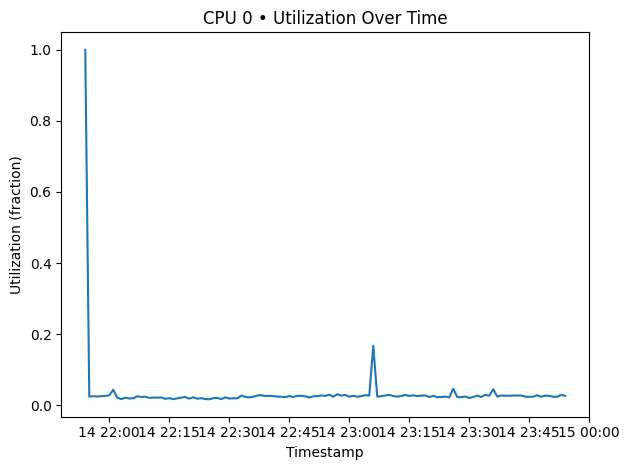

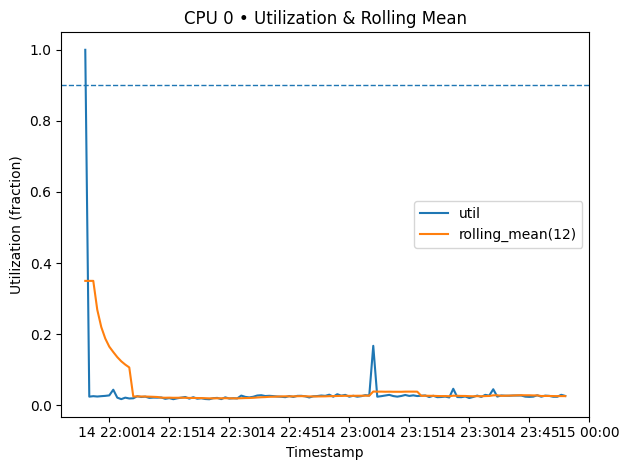

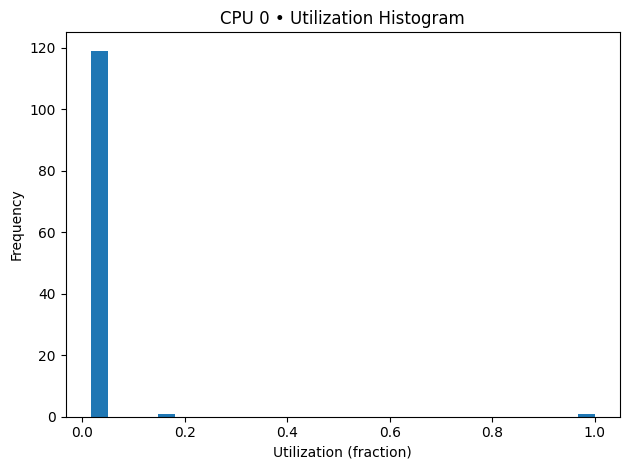

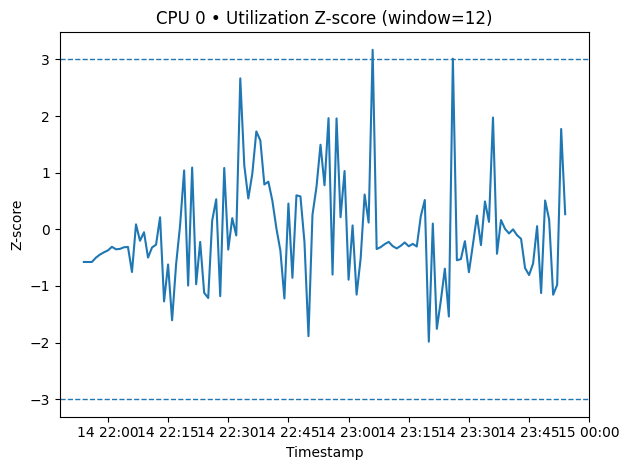

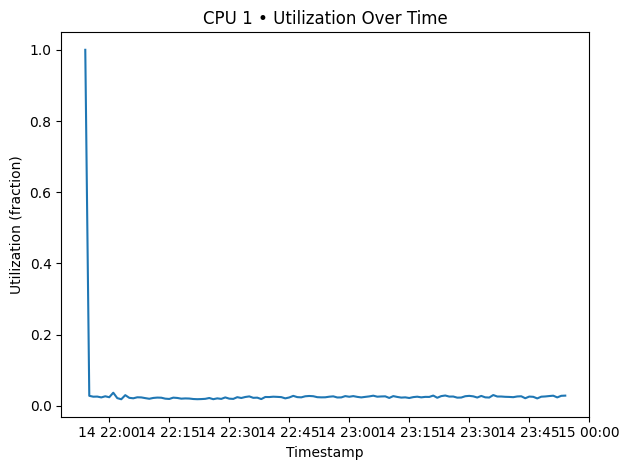

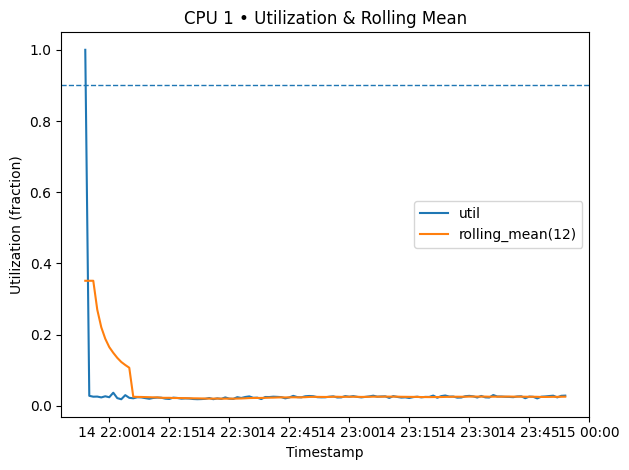

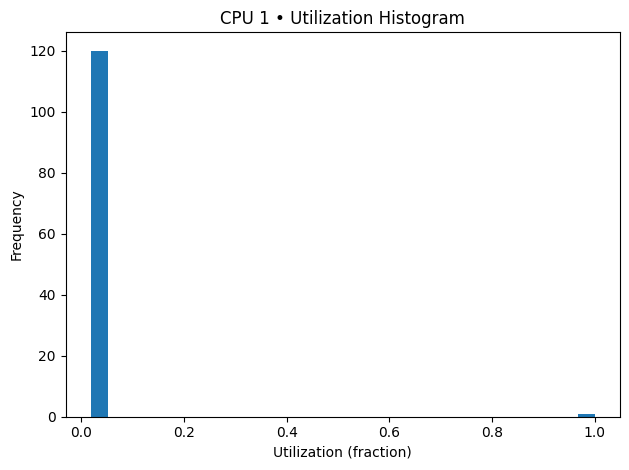

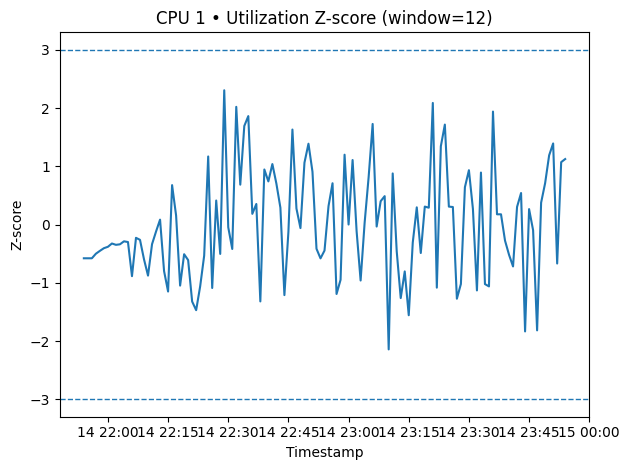

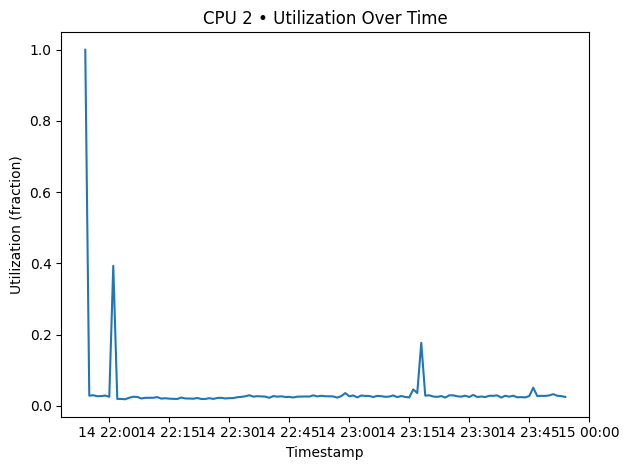

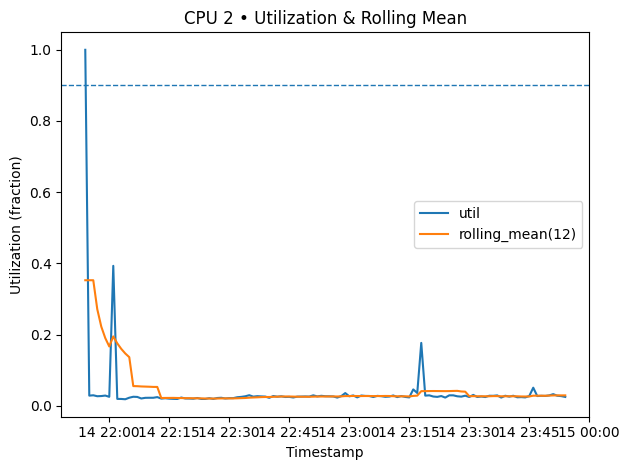

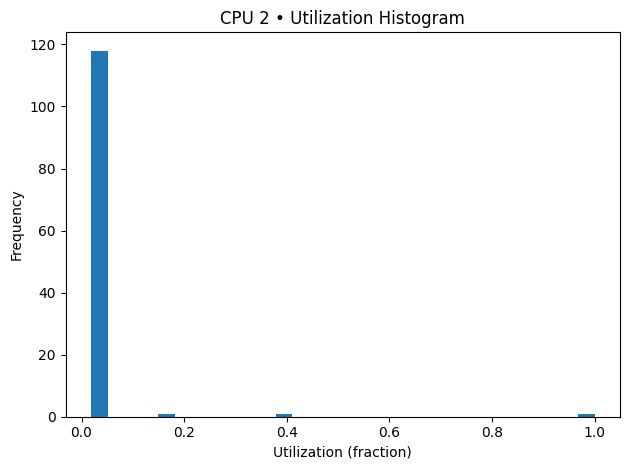

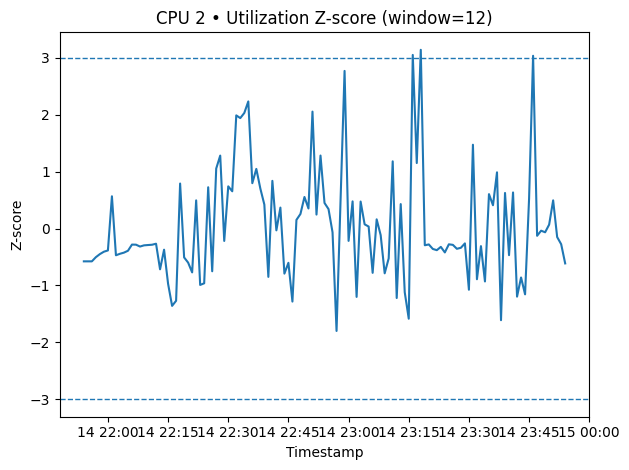

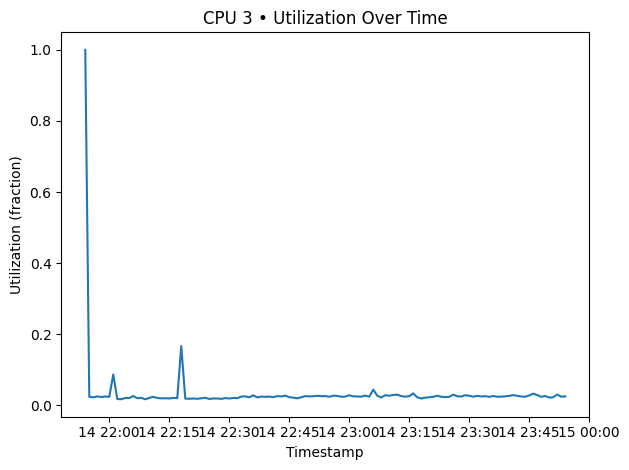

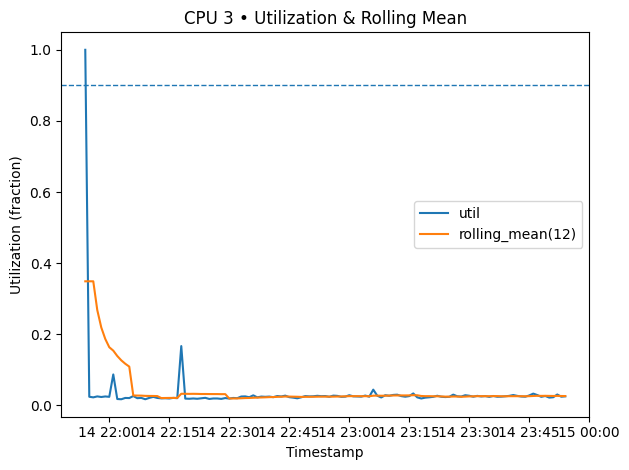

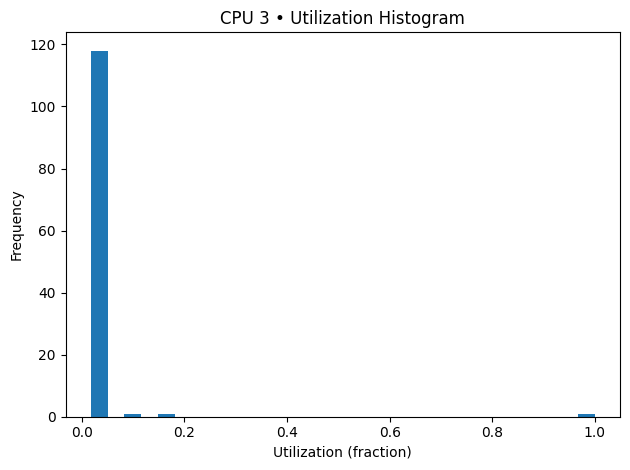

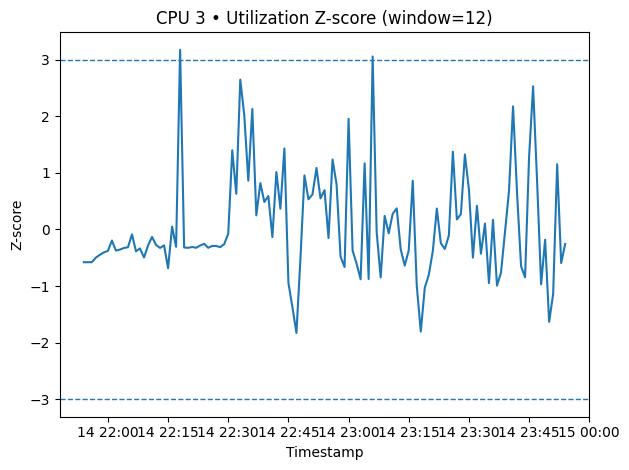

In [ ]:
# === PRINT GRAPHS FOR ALL CPUS ===
# (Append this below your current script)

import matplotlib.pyplot as plt

# All CPUs present
cpus = sorted(util_df["cpu"].dropna().unique(), key=lambda k: (isinstance(k, str), k))

for cpu in cpus:
    # Utilization over time
    sub_u = util_df[util_df["cpu"] == cpu].sort_values("timestamp")
    plt.figure()
    plt.plot(sub_u["timestamp"], sub_u["util"])
    plt.title(f"CPU {cpu} • Utilization Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Utilization (fraction)")
    plt.tight_layout()
    plt.show()

    # Utilization with rolling mean overlay
    sub_x = X[X["cpu"] == cpu].sort_values("timestamp")
    plt.figure()
    plt.plot(sub_x["timestamp"], sub_x["util"], label="util")
    plt.plot(sub_x["timestamp"], sub_x["util_roll_mean"], label=f"rolling_mean({ROLL_WIN})")
    plt.axhline(y=0.90, linestyle="--", linewidth=1)  # high-util threshold guideline
    plt.title(f"CPU {cpu} • Utilization & Rolling Mean")
    plt.xlabel("Timestamp")
    plt.ylabel("Utilization (fraction)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Histogram of utilization
    plt.figure()
    plt.hist(sub_u["util"].dropna(), bins=30)
    plt.title(f"CPU {cpu} • Utilization Histogram")
    plt.xlabel("Utilization (fraction)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Z-score of utilization (rolling window)
    plt.figure()
    plt.plot(sub_x["timestamp"], sub_x["util_roll_z"])
    plt.axhline(y=3.0, linestyle="--", linewidth=1)   # typical anomaly band
    plt.axhline(y=-3.0, linestyle="--", linewidth=1)
    plt.title(f"CPU {cpu} • Utilization Z-score (window={ROLL_WIN})")
    plt.xlabel("Timestamp")
    plt.ylabel("Z-score")
    plt.tight_layout()
    plt.show()


In [ ]:
# === ANOMALY DETECTION WITH ISOLATION FOREST (per CPU) ===
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

CONTAMINATION = 0.01  # expected fraction of anomalies; tune 0.005–0.03

models = {}
all_scored = []

for cpu_val, g in X.groupby("cpu"):
    feats = g[feature_cols]
    meta  = g[["timestamp", "cpu", "instance"]].reset_index(drop=True)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("iso", IsolationForest(
            n_estimators=300,
            max_samples="auto",
            contamination=CONTAMINATION,
            random_state=42,
            n_jobs=-1,
        )),
    ])

    pipe.fit(feats)
    # decision_function > 0 = normal, < 0 = anomaly (we flip sign so higher score = more anomalous)
    anomaly_score = -pipe.decision_function(feats)
    is_anom = pipe.predict(feats) == -1

    scored = meta.copy()
    scored["anomaly_score"] = anomaly_score
    scored["is_anomaly"] = is_anom.astype(bool)

    # attach a few helpful columns for review
    scored = scored.merge(
        g[["timestamp", "util", "util_roll_mean", "util_roll_z"]],
        on="timestamp", how="left"
    )

    models[cpu_val] = pipe
    all_scored.append(scored)

anomalies_df = pd.concat(all_scored, ignore_index=True).sort_values(["cpu", "timestamp"])

print("\n=== Anomaly counts by CPU ===")
print(anomalies_df.groupby("cpu")["is_anomaly"].sum())

print("\n=== Top 10 most anomalous points overall ===")
print(
    anomalies_df.sort_values("anomaly_score", ascending=False)
                .head(10)
                .to_string(index=False)
)



=== Anomaly counts by CPU ===
cpu
0    2
1    2
2    2
3    2
Name: is_anomaly, dtype: int64

=== Top 10 most anomalous points overall ===
                timestamp  cpu               instance  anomaly_score  is_anomaly     util  util_roll_mean  util_roll_z
2025-08-14 21:54:01+00:00    1 ctdev9306.clonetab.com       0.045390        True 1.000000        0.351500    -0.579575
2025-08-14 22:01:01+00:00    2 ctdev9306.clonetab.com       0.027514        True 0.393000        0.194750     0.567064
2025-08-14 21:54:01+00:00    3 ctdev9306.clonetab.com       0.018020        True 1.000000        0.349111    -0.578828
2025-08-14 21:54:01+00:00    0 ctdev9306.clonetab.com       0.017258        True 1.000000        0.349889    -0.576166
2025-08-14 21:54:01+00:00    2 ctdev9306.clonetab.com       0.009794        True 1.000000        0.352556    -0.576458
2025-08-14 22:18:01+00:00    3 ctdev9306.clonetab.com       0.008069        True 0.167000        0.032903     3.173368
2025-08-14 23:06:01+00:00  

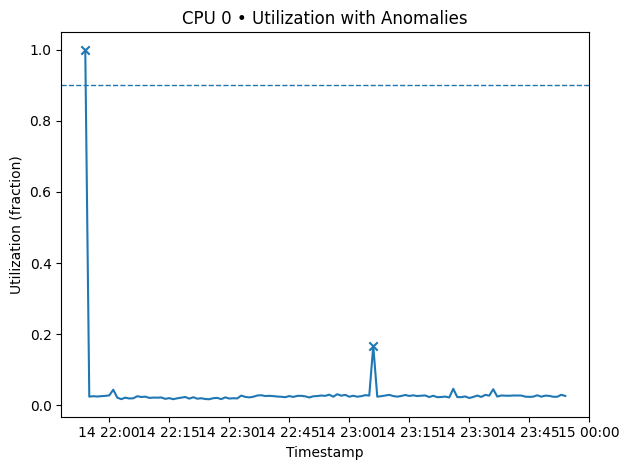

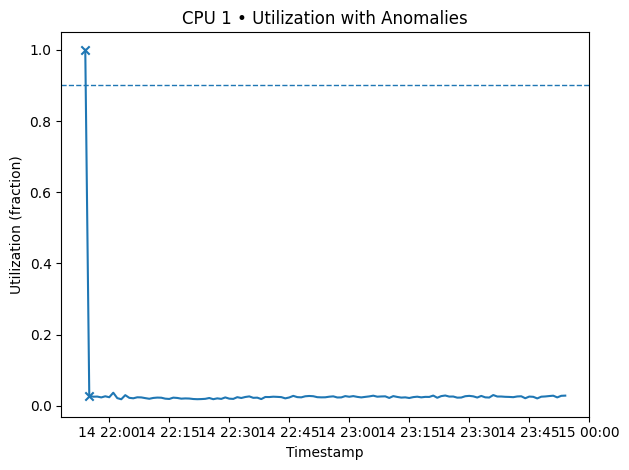

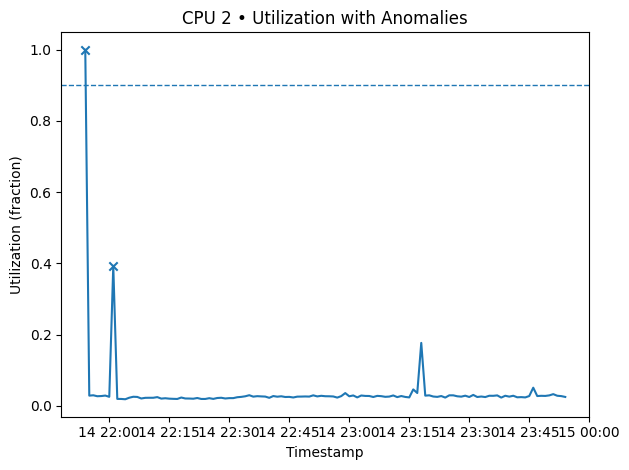

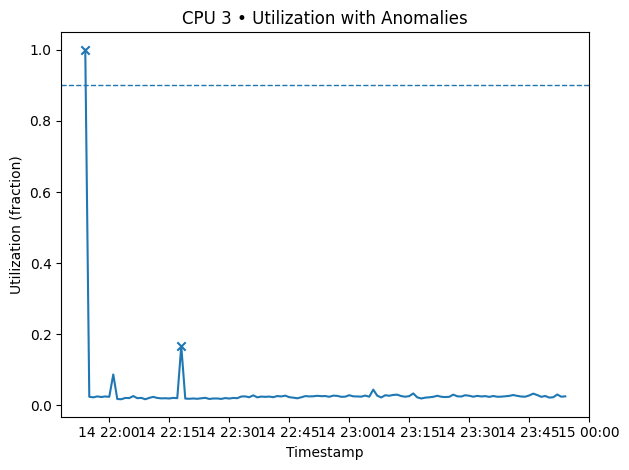

In [ ]:
# (Run in a notebook; uses matplotlib; one plot per CPU)
import matplotlib.pyplot as plt

for cpu_val in sorted(anomalies_df["cpu"].unique(), key=lambda k: (isinstance(k, str), k)):
    sub_u = util_df[util_df["cpu"] == cpu_val].sort_values("timestamp")
    sub_a = anomalies_df[(anomalies_df["cpu"] == cpu_val) & (anomalies_df["is_anomaly"])]

    plt.figure()
    plt.plot(sub_u["timestamp"], sub_u["util"], label="util")
    plt.axhline(0.90, linestyle="--", linewidth=1)   # reference line
    # mark anomalies
    plt.scatter(sub_a["timestamp"], sub_a["util"], marker="x")
    plt.title(f"CPU {cpu_val} • Utilization with Anomalies")
    plt.xlabel("Timestamp")
    plt.ylabel("Utilization (fraction)")
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================
# Explain CPU spikes from the original CSV
# - Builds CPU utilization from node_cpu_seconds_total
# - Detects spikes with rolling z-score
# - Around each spike, ranks metrics that co-spike and/or lead CPU
# - Prints "why" summaries and displays a ranked table
# ============================================

import pandas as pd
import numpy as np
import re
from pathlib import Path

# ---------- CONFIG ----------
FILE_PATH = "/content/drive/MyDrive/all_metrics_pivot.csv"  # <-- change if needed
TARGET_CPU = None      # e.g., 0 to focus on cpu=0, or None for all
ROLL_WIN = 12          # samples for rolling mean/std
Z_THRESH = 3.0         # spike threshold on rolling z-score
PRE_POST_WINDOW = 3    # samples before/after spike (index-based)
MAX_CAUSE_METRICS = 10 # top metrics to show per spike
MAX_LAG = 5            # +/- lag (samples) for cross-corr
ASSUME_DT_SEC = 1.0    # used if timestamps cannot be parsed
# ----------------------------

# Optional: prettier display in notebooks (safe if not available)
try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# ---------- Helpers ----------
def _extract_label(text: str, key: str):
    if not isinstance(text, str):
        return None
    m = re.search(fr'{key}\s*=\s*"?([^,|}}"]+)"?', text)
    return m.group(1) if m else None

def wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    metric_col = df.columns[0]
    time_cols = [c for c in df.columns if c != metric_col]
    long_df = df.melt(id_vars=[metric_col], value_vars=time_cols,
                      var_name="timestamp_raw", value_name="value")
    long_df.rename(columns={metric_col: "metric_id"}, inplace=True)
    long_df["value"] = pd.to_numeric(long_df["value"], errors="coerce")
    return long_df

def parse_timestamps(long_df: pd.DataFrame) -> pd.DataFrame:
    ts = pd.to_datetime(long_df["timestamp_raw"], errors="coerce", utc=True)
    if ts.isna().mean() < 0.5:
        long_df["timestamp"] = ts
    else:
        # Fallback to ordinal seconds based on column order within each metric
        long_df["_ord"] = long_df.groupby("metric_id")["timestamp_raw"].transform(
            lambda s: pd.factorize(s, sort=True)[0]
        )
        long_df["timestamp"] = pd.to_datetime(long_df["_ord"], unit="s", utc=True)
    return long_df

def add_labels(long_df: pd.DataFrame) -> pd.DataFrame:
    long_df["cpu"] = long_df["metric_id"].map(lambda s: _extract_label(s, "cpu"))
    long_df["mode"] = long_df["metric_id"].map(lambda s: _extract_label(s, "mode"))
    long_df["instance"] = long_df["metric_id"].map(lambda s: _extract_label(s, "instance"))
    def _maybe_int(x):
        return int(x) if isinstance(x, str) and x.isdigit() else x
    long_df["cpu"] = long_df["cpu"].map(_maybe_int)
    return long_df

def counter_to_rate(df_long: pd.DataFrame) -> pd.DataFrame:
    df = df_long.copy()
    df.sort_values(["metric_id", "timestamp"], inplace=True)
    dt = df.groupby("metric_id")["timestamp"].diff().dt.total_seconds()
    df["dt"] = dt.fillna(ASSUME_DT_SEC).replace(0, ASSUME_DT_SEC)
    df["dv"] = df.groupby("metric_id")["value"].diff()
    df.loc[df["dv"] < 0, "dv"] = 0.0  # counter reset
    df["rate"] = df["dv"] / df["dt"]
    return df

def utilization_from_modes(rate_df: pd.DataFrame) -> pd.DataFrame:
    cpu_df = rate_df[rate_df["metric_id"].str.contains("node_cpu_seconds_total", na=False)]
    pivot = cpu_df.pivot_table(
        index=["timestamp","cpu","instance"],
        columns="mode",
        values="rate",
        aggfunc="sum"
    ).sort_index()

    if "idle" in pivot.columns:
        util = 1.0 - pivot["idle"]
    else:
        util = pivot.sum(axis=1)  # best-effort fallback

    out = util.to_frame(name="util").reset_index()
    out["util"] = out["util"].clip(0, 1.5)
    return out

def rolling_z(series: pd.Series, win: int) -> pd.Series:
    m = series.rolling(win, min_periods=3).mean()
    s = series.rolling(win, min_periods=3).std()
    return (series - m) / (s + 1e-8)

def detect_spikes(util_df: pd.DataFrame, z_thresh: float, win: int):
    df = util_df.sort_values(["cpu","timestamp"]).copy()
    df["util_z"] = df.groupby("cpu")["util"].transform(lambda s: rolling_z(s, win))
    spikes = df[df["util_z"] >= z_thresh].copy()
    return df, spikes

def categorize_metric(metric_id: str) -> str:
    s = (metric_id or "").lower()
    if any(k in s for k in ["disk_", "node_disk", "io", "iops", "iostat", "dm_"]):
        return "Disk I/O"
    if any(k in s for k in ["net_", "network", "node_network", "rx", "tx"]):
        return "Network"
    if any(k in s for k in ["load", "procs", "process", "runnable", "runqueue"]):
        return "System Load/Processes"
    if any(k in s for k in ["mem", "memory", "swap", "page", "pgfault", "pgmaj"]):
        return "Memory/Swap"
    if any(k in s for k in ["context", "ctxt", "sched", "softirq", "irq"]):
        return "Scheduling/Interrupts"
    if any(k in s for k in ["file", "inode", "fs_", "filesystem"]):
        return "Filesystem"
    return "Other"

def best_lagged_corr(x: pd.Series, y: pd.Series, max_lag: int):
    x = (x - x.mean()) / (x.std() + 1e-8)
    y = (y - y.mean()) / (y.std() + 1e-8)
    best = (0, -np.inf)
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            xs = x[-lag:].reset_index(drop=True)
            ys = y[:len(xs)].reset_index(drop=True)
        elif lag > 0:
            ys = y[lag:].reset_index(drop=True)
            xs = x[:len(ys)].reset_index(drop=True)
        else:
            n = min(len(x), len(y))
            xs = x.iloc[:n].reset_index(drop=True)
            ys = y.iloc[:n].reset_index(drop=True)
        if len(xs) < 5:
            continue
        c = float(np.corrcoef(xs, ys)[0,1])
        if abs(c) > abs(best[1]):
            best = (lag, c)
    return best  # lag>0 => metric leads CPU

# ---------- Load & prepare ----------
df = pd.read_csv(FILE_PATH, low_memory=False)
long_df = wide_to_long(df)
long_df = parse_timestamps(long_df)
long_df = add_labels(long_df)

# Build per-metric rates (for counters)
rate_df = counter_to_rate(long_df)

# CPU utilization & spikes
util_df = utilization_from_modes(rate_df)
if TARGET_CPU is not None:
    util_df = util_df[util_df["cpu"] == TARGET_CPU]

util_seq, spikes = detect_spikes(util_df, Z_THRESH, ROLL_WIN)

if spikes.empty:
    print("No CPU spikes detected with current thresholds. Try lowering Z_THRESH or ROLL_WIN.")
else:
    # Consider all other metrics (exclude CPU counter itself)
    others = rate_df[~rate_df["metric_id"].str.contains("node_cpu_seconds_total", na=False)].copy()
    # Build a z-score for each metric (use rate if available, else value)
    others.sort_values(["metric_id","timestamp"], inplace=True)
    others["value_z"] = others.groupby("metric_id")["value"].transform(lambda s: rolling_z(s, ROLL_WIN))
    if "rate" in others.columns:
        others["rate_z"] = others.groupby("metric_id")["rate"].transform(lambda s: rolling_z(s, ROLL_WIN))
        others["signal"] = np.where(others["rate"].notna(), others["rate"], others["value"])
        others["signal_z"] = np.where(others["rate"].notna(), others["rate_z"], others["value_z"])
    else:
        others["signal"] = others["value"]
        others["signal_z"] = others["value_z"]

    # Explain each spike
    explanations = []
    detailed_rows = []

    for (cpu_val), cpu_df in util_seq.groupby("cpu"):
        # sort timestamps for index-based windows
        cpu_df = cpu_df.sort_values("timestamp")
        tlist = list(cpu_df["timestamp"])

        # spikes for this cpu
        sp_cpu = spikes[spikes["cpu"] == cpu_val].sort_values("timestamp")
        if sp_cpu.empty:
            continue

        for _, sp in sp_cpu.iterrows():
            ts = sp["timestamp"]
            util_at = float(sp["util"])
            util_z_at = float(sp["util_z"])

            # window indices around spike
            if ts not in tlist:
                continue
            idx = tlist.index(ts)
            i0 = max(0, idx - PRE_POST_WINDOW)
            i1 = min(len(tlist) - 1, idx + PRE_POST_WINDOW)
            win_times = set(tlist[i0:i1+1])

            # Candidate metrics in window
            cand = others[others["timestamp"].isin(win_times)].copy()
            if cand.empty:
                explanations.append(
                    f"[cpu={cpu_val}] {ts} util={util_at:.2f} (z={util_z_at:.2f}) → No co-moving metrics found in window."
                )
                continue

            # Compute baseline before spike (preceding ROLL_WIN samples)
            baseline = (others[others["timestamp"] < ts]
                        .groupby("metric_id")
                        .tail(ROLL_WIN)[["metric_id","signal"]]
                        .groupby("metric_id")["signal"].mean()
                        .rename("baseline_signal"))
            cand = cand.merge(baseline, on="metric_id", how="left")
            cand["delta"] = cand["signal"] - cand["baseline_signal"]
            cand["pct_change"] = cand["delta"] / (cand["baseline_signal"].replace(0, np.nan))

            # Aggregate per metric within the window
            agg = (cand.groupby("metric_id")
                   .agg(
                       category=("metric_id", lambda s: categorize_metric(s.iloc[0])),
                       max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
                       mean_z=("signal_z", "mean"),
                       mean_delta=("delta", "mean"),
                       mean_pct_change=("pct_change", "mean")
                   )
                   .reset_index())

            # Build a band around the spike for lagged correlation
            band_i0 = max(0, idx - (ROLL_WIN + PRE_POST_WINDOW))
            band_i1 = min(len(tlist) - 1, idx + (ROLL_WIN + PRE_POST_WINDOW))
            band_times = tlist[band_i0:band_i1+1]

            cpu_band = cpu_df[cpu_df["timestamp"].isin(band_times)].set_index("timestamp")["util"]

            # Preselect by z to cut correlation cost
            preselect = agg.sort_values("max_abs_z", ascending=False).head(MAX_CAUSE_METRICS * 5)["metric_id"].tolist()

            # Compute best lagged corr for preselected metrics
            lag_rows = []
            for m in preselect:
                ms = others[others["metric_id"] == m].set_index("timestamp")["signal"]
                pair = pd.concat([cpu_band, ms], axis=1, join="inner").dropna()
                if pair.shape[0] < 8:
                    continue
                lag, corr = best_lagged_corr(pair.iloc[:,0], pair.iloc[:,1], MAX_LAG)
                lag_rows.append((m, lag, corr))
            lag_df = pd.DataFrame(lag_rows, columns=["metric_id","best_lag","best_corr"])

            merged = agg.merge(lag_df, on="metric_id", how="left")
            merged["cpu"] = cpu_val
            merged["spike_time"] = ts
            merged["util_at_spike"] = util_at
            merged["util_z_at_spike"] = util_z_at

            # Rank score: co-spike intensity × (1 + |corr|)
            merged["rank_score"] = merged["max_abs_z"].fillna(0) * (1 + merged["best_corr"].abs().fillna(0))
            merged = merged.sort_values(["rank_score","max_abs_z","best_corr"], ascending=False).head(MAX_CAUSE_METRICS)

            # Save detailed rows
            detailed_rows.append(merged)

            # Build a short natural explanation
            reasons = []
            for _, r in merged.iterrows():
                lag_desc = ("leads CPU by %d" % r["best_lag"]) if pd.notna(r["best_lag"]) and r["best_lag"] > 0 \
                           else ("lags CPU by %d" % abs(r["best_lag"])) if pd.notna(r["best_lag"]) and r["best_lag"] < 0 \
                           else "synchronous/unclear"
                reasons.append(
                    f"{r['category']}: '{r['metric_id']}' (|z|≈{r['max_abs_z']:.1f}, corr≈{(r['best_corr'] if pd.notna(r['best_corr']) else 0):.2f}, {lag_desc})"
                )

            msg = (
                f"[cpu={cpu_val}] Spike @ {pd.to_datetime(ts)}: util={util_at:.2f} (z={util_z_at:.2f}).\n"
                f"Likely contributors:\n - " + "\n - ".join(reasons)
            )
            explanations.append(msg)

    # ---- Print explanations and display detailed table ----
    print("\n================ Explanations (WHY) ================\n")
    for e in explanations:
        print(e, "\n")

    if detailed_rows:
        report = pd.concat(detailed_rows, ignore_index=True)
        # Reorder/trim columns for readability
        cols = [
            "cpu","spike_time","util_at_spike","util_z_at_spike",
            "metric_id","category","max_abs_z","mean_z","mean_delta","mean_pct_change",
            "best_corr","best_lag","rank_score"
        ]
        cols = [c for c in cols if c in report.columns]
        report = report[cols].copy()
        display(report)
    else:
        print("No co-moving metrics found near detected spikes (consider relaxing thresholds).")


/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),
/tmp/ipython-input-323177807.py:226: RuntimeWarning: All-NaN axis encountered
  max_abs_z=("signal_z", lambda s: float(np.nanmax(np.abs(s)))),


================ Explanations (WHY) ================

[cpu=0.0] Spike @ 2025-08-14 23:06:01+00:00: util=0.17 (z=3.17).
Likely contributors:
 - Memory/Swap: 'go_memstats_heap_released_bytes|instance=localhost:12345,job=alloy' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - System Load/Processes: 'alloy_resources_process_resident_memory_bytes|instance=localhost:12345,job=alloy' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - System Load/Processes: 'process_resident_memory_bytes|instance=localhost:12345,job=alloy' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - Disk I/O: 'node_sockstat_TCP_mem_bytes|instance=ctdev9306.clonetab.com,job=integrations/unix' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - Disk I/O: 'node_disk_read_bytes_total|device=sdb,instance=ctdev9306.clonetab.com,job=integrations/unix' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - Memory/Swap: 'go_memstats_gc_sys_bytes|instance=192.168.41.173:9090,job=prometheus' (|z|≈3.2, corr≈-inf, synchronous/unclear)
 - Memory/Swap: 'go_memstats_

,cpu,spike_time,util_at_spike,util_z_at_spike,metric_id,category,max_abs_z,mean_z,mean_delta,mean_pct_change,best_corr,best_lag,rank_score
0,0.0,2025-08-14 23:06:01+00:00,0.167167,3.170245,go_memstats_heap_released_bytes|instance=local...,Memory/Swap,3.175426,0.412393,3432.838095,NaN,-inf,0.0,inf
1,0.0,2025-08-14 23:06:01+00:00,0.167167,3.170245,alloy_resources_process_resident_memory_bytes|...,System Load/Processes,3.175426,0.206197,-2655.898413,-0.804926,-inf,0.0,inf
2,0.0,2025-08-14 23:06:01+00:00,0.167167,3.170245,process_resident_memory_bytes|instance=localho...,System Load/Processes,3.175426,0.206197,-2655.898413,-0.804926,-inf,0.0,inf
3,0.0,2025-08-14 23:06:01+00:00,0.167167,3.170245,node_sockstat_TCP_mem_bytes|instance=ctdev9306...,Disk I/O,3.175426,0.288675,203.174603,0.714286,-inf,0.0,inf
4,0.0,2025-08-14 23:06:01+00:00,0.167167,3.170245,"node_disk_read_bytes_total|device=sdb,instance...",Disk I/O,3.175426,0.329914,370.590476,NaN,-inf,0.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,3.0,2025-08-14 23:06:01+00:00,0.044500,3.055526,go_memstats_gc_sys_bytes|instance=192.168.41.1...,Memory/Swap,3.175426,0.412393,156.038095,NaN,-inf,0.0,inf
66,3.0,2025-08-14 23:06:01+00:00,0.044500,3.055526,go_memstats_stack_inuse_bytes|instance=192.168...,Memory/Swap,3.175426,0.756054,318.577778,1.400000,-inf,0.0,inf
67,3.0,2025-08-14 23:06:01+00:00,0.044500,3.055526,go_memstats_stack_sys_bytes|instance=192.168.4...,Memory/Swap,3.175426,0.756054,318.577778,1.400000,-inf,0.0,inf
68,3.0,2025-08-14 23:06:01+00:00,0.044500,3.055526,node_memory_Active_file_bytes|instance=ctdev93...,Disk I/O,3.175426,0.329914,48.761905,NaN,-inf,0.0,inf


In [ ]:
import pandas as pd
import numpy as np

# --- CONFIG ---
FILE_PATH = "/content/drive/MyDrive/all_metrics_pivot.csv"
ROLL_WIN = 5
Z_THRESH = 3.0

# --- LOAD CSV ---
df = pd.read_csv(FILE_PATH, low_memory=False)
col0 = df.columns[0]

# convert metrics to numeric
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- FOCUS: only CPU metrics ---
cpu_df = df[df[col0].str.contains("cpu", case=False, na=False)].copy()
cpu_df["cpu_id"] = cpu_df[col0].str.extract(r'cpu\s*=\s*"?([^,|}"]+)"?', expand=False)

# aggregate CPU usage (sum across cores)
cpu_vals = cpu_df.iloc[:, 1:].sum(axis=0)

# rolling z-score
roll_mean = cpu_vals.rolling(ROLL_WIN, min_periods=1).mean()
roll_std  = cpu_vals.rolling(ROLL_WIN, min_periods=1).std().replace(0, np.nan)
z_scores  = (cpu_vals - roll_mean) / roll_std

# detect spike points
spike_points = z_scores[z_scores > Z_THRESH].index.tolist()

# --- ANALYZE SPIKE CONTEXT ---
explanations = []
for spike in spike_points:
    # define local window around spike
    win_cols = cpu_vals.index[max(0, spike-ROLL_WIN):spike+ROLL_WIN+1]

    # check other metrics
    sub = df.set_index(col0).iloc[:, 1:][win_cols].dropna(how="all")
    changes = sub.apply(lambda row: row.pct_change().mean(skipna=True), axis=1)

    # rank largest changes
    top = changes.abs().sort_values(ascending=False).head(3)

    msg = f"At spike {spike}: "
    for metric, val in top.items():
        direction = "increased" if val > 0 else "decreased"
        msg += f"{metric} {direction} ({val:.2%}); "
    explanations.append(msg)

# --- OUTPUT ---
print("=== Natural-language Explanations for CPU Spikes ===\n")
for e in explanations:
    print("-", e)


TypeError: unsupported operand type(s) for +: 'int' and 'str'